# Autoencoder Univariate Training (Expiriment 1)

 Vinayak Sharma
  
 This notebook aims to train an autoencoder on univariate timeseries data from EKS Performance metrics. The training data is 'non-anomalous'. 

 The model and implementation techniques can be found in the following github: https://github.com/emerelte/kad
 
 The research paper that this work is based on can be found here: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9925210

------

## Imports

In [2]:
# !pip install -r /root/eks-ml-pipeline/modeling/kad/kad/requirements.txt

In [3]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers

import kad.visualization.visualization as visualization
from kad.kad_utils import kad_utils
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.model.autoencoder_model as autoencoder_model
from kad.model.sarima_model import SarimaModel
import kad.models_evaluation.models_evaluator as models_evaluator

from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

In [4]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [5]:
training_df_full = pd.read_parquet('/root/eks-ml-pipeline/healthy_train_data_eks')

In [6]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization']

In [7]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

In [8]:
training_df.head()

,Timestamp,InstanceId,node_cpu_utilization
0,2022-06-07 20:05:29.974,i-02ff02960edb2ede8,0.177143
1,2022-06-07 20:05:35.207,i-08a448576feb6e96c,0.317641
2,2022-06-07 21:00:16.109,i-093473861e74eaf2d,0.947020
3,2022-06-07 20:05:44.540,i-01470d8d8e7b4fd2f,2.933662
4,2022-06-07 20:05:40.883,i-0b36e8825c482f762,1.876441


-----

# Build out Dataset for training on one node

(Although the goal is to be able to train on a variety of nodes using transfer learning , and also eventually shifting over to multivariate autoencoders for anomaly detection. We want to make sure our fundementals are strong and train the autoencoder on a simple dataset of one node for one day)

In [9]:
training_df_one_node = training_df[training_df.InstanceId == 'i-0b36e8825c482f762']

# training_df_one_node.head(65)

In [10]:
training_df_one_node.shape

(1430, 3)

In [11]:
training_df_one_node.head()

,Timestamp,InstanceId,node_cpu_utilization
4,2022-06-07 20:05:40.883,i-0b36e8825c482f762,1.876441
8,2022-06-07 21:00:35.491,i-0b36e8825c482f762,1.831831
16,2022-06-07 20:06:41.490,i-0b36e8825c482f762,1.809944
20,2022-06-07 21:01:41.885,i-0b36e8825c482f762,1.877931
28,2022-06-07 20:07:30.653,i-0b36e8825c482f762,1.837361


reformat our dataframe

In [12]:
## drop the instanceId
training_df_one_node = training_df_one_node.drop("InstanceId",1, inplace=False)


##set timestamp as the index
training_df_one_node = training_df_one_node.set_index('Timestamp')

##add a ground truth column
training_df_one_node['gt_is_anomaly'] = False

##ensure the data is sorted!!
training_df_one_node = training_df_one_node.sort_index()

In [13]:
training_df_one_node.head()

,node_cpu_utilization,gt_is_anomaly
Timestamp,,
2022-06-07 00:16:43.039,1.842516,False
2022-06-07 00:17:38.115,1.887993,False
2022-06-07 00:18:42.693,1.849763,False
2022-06-07 00:19:32.388,1.831488,False
2022-06-07 00:20:33.817,1.880775,False


Lets quickly visualize the data that we have

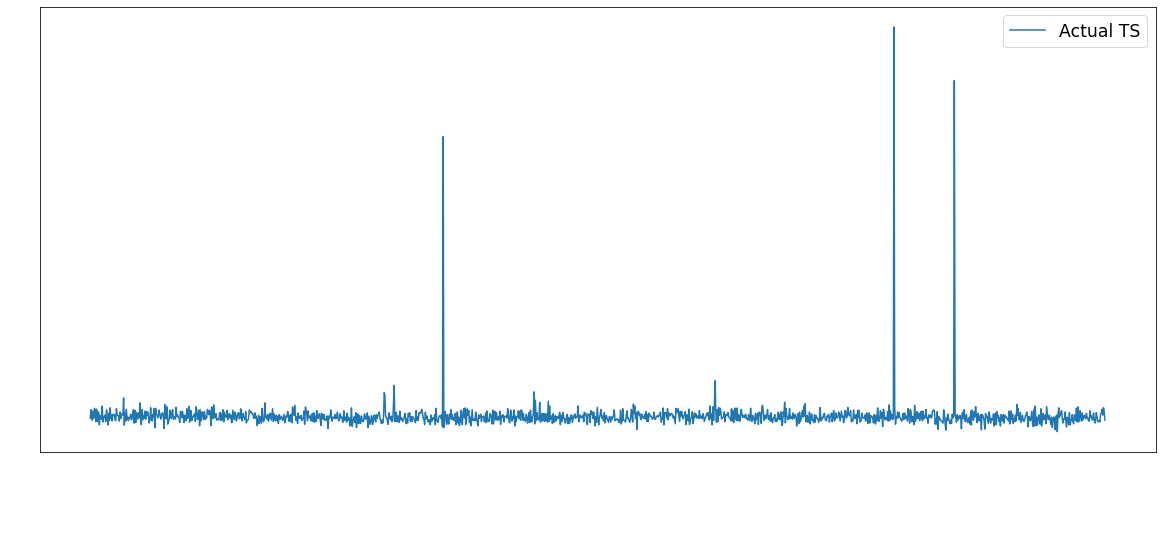

In [14]:
visualization.visualize(results_df=training_df_one_node, metric_name="node_cpu_utilization", title="Original df")

Next we will apply a minmax scaler to the dataset, to ensure we are able to generalize our model

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_df_one_node["node_cpu_utilization"] = scaler.fit_transform(training_df_one_node.values)


graph the minmax scaler applied dataset

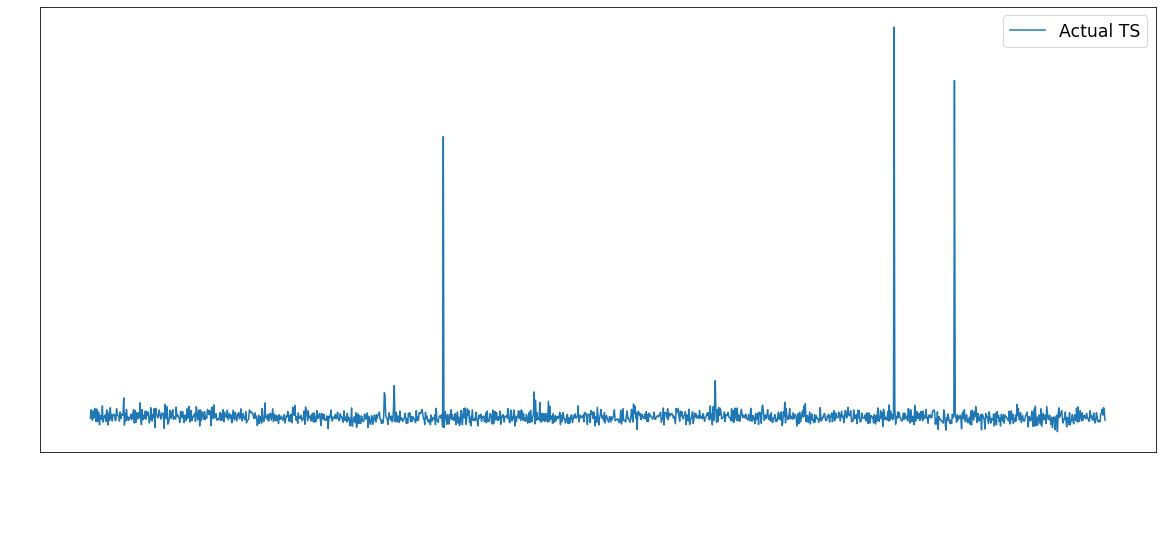

In [16]:
visualization.visualize(results_df=training_df_one_node, metric_name="node_cpu_utilization", title="Original df")

----

## Model Time

In [17]:
autoencoder_model = importlib.reload(autoencoder_model)

In [18]:
model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

In [19]:
values_df = training_df_one_node[["node_cpu_utilization"]]

In [20]:
values_df.head()

,node_cpu_utilization
timestamp,
2022-06-07 00:16:43.039,0.033372
2022-06-07 00:17:38.115,0.054126
2022-06-07 00:18:42.693,0.036680
2022-06-07 00:19:32.388,0.028340
2022-06-07 00:20:33.817,0.050832


In [21]:
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=.15)

In [22]:
val_err = model.train(train_df)


IndexError: tuple index out of range

In [ ]:
val_err

In [ ]:
results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 60
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    if len(test_df.iloc[i:i + SAMPLES_TO_PREDICT]) < SAMPLES_TO_PREDICT:
        break
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

evaluation_df = results_df.copy()
evaluation_df[kad_utils.GROUND_TRUTH_COLUMN] = training_df_one_node[kad_utils.GROUND_TRUTH_COLUMN]
visualization.visualize(evaluation_df, "node_cpu_utilization")
plt.savefig("exaplary_visualization.png", type="PNG")